# Basement topography and sediment thickness beneath Antarctica's Ross Ice Shelf

Follow along this Jupyter notebook to see the code behind the analysis and figures for Tankersley et al., 2022. This notebook, and much of the data used are located in a github repository (https://github.com/mdtanker/RIS_basement_sediment), as well as being hosted on PANGAEA (https://doi.pangaea.de/10.1594/PANGAEA.941238). Use the Table of Content panel on the left for easy navigation of the notebook section.

Please let me know if you have any questions. Thanks to Matt Siegfried for providing a template for figure creation in PyGMT, from Venturelli et al., 2020.

*Matt Tankersley*  
*Antarctic Research Centre, Victoria University of Wellington, NZ*  
*matthew.tankersley@vuw.ac.nz*  
*20 March, 2022*

Tankersley, M. D., Horgan, H. J., Siddoway, C. S., Caratori Tontini, F., & Tinto, K. J. (2022).  
Basement topography and sediment thickness beneath Antarctica’s Ross Ice Shelf. _Geophysical Research Letters._

In [1]:
# import necessary python packages
import pygmt
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import scipy.interpolate 
from scipy import stats
import itertools
import matplotlib.animation
import random
import os

In [2]:
# all file paths assume this notebook is in /RIS_basement_sediment
os.getcwd()

'C:\\Users\\mtankersley\\Documents\\Python_Scripts\\RIS_basement_sediment'

# Intro

## Datasets

All the data used in this notebook and the figures accompanying this paper is publically available. Some of it is in in the \data\input folder of the github repository where this notebook was downloaded from: https://github.com/mdtanker/RIS_basement_sediment

The following datasets will need to be downloaded from the respective URL's and added the "data/input" folder.
* [BedMachine bathymetry](https://nsidc.org/data/NSIDC-0756/versions/2); from [Morlighem et al., 2020](https://doi.org/10.1038/s41561-019-0510-8)
* [MODIS-MOA satellite imagery](https://nsidc.org/data/NSIDC-0593); from [Scambos et al., 2007](https://doi.org/10.1016/j.rse.2006.12.020)
    - download the geotiff "moa750_2009_hp1_v02.0.tif"
* [Continent-wide Moho depths](http://www.seismolab.org/model/antarctica/lithosphere/index.html#an1-crust); from [An et al., 2015](https://doi.org/10.1002/2014JB011332)
    - download "AN1-CRUST.tar.gz"
    - unzip and place .grd file in data/input folder
* [Ross Sea seismic basement depths](https://doi.pangaea.de/10.1594/PANGAEA.864906); compilation from [Lindeque et al., 2016](https://doi.org/10.1002/2016GC006401), which used ANTOSTRAT data from [Brancolini et al., 1995](https://doi.org/10.1002/9781118669013.app1)
    - download the netcdf "sedthick_total_v2_5km_epsg3031.nc"
    - subtracted from sediment thickness to get basement depths
* [Local Moho model](https://sites.google.com/view/weisen/research-products?authuser=0); from [Shen et al., 2018]( https://doi.org/10.1029/2017JB015346)
    - download "moho.final.dat"
* [Mean Geotherma heat flux model](https://doi.org/10.5194/tc-14-3843-2020); from [Burton-Johnson et al. 2020](https://doi.org/10.5194/tc-14-3843-2020)
    - download "Mean.tif" from the supplement

The following datasets were used; but are supplied in the repository.
* [MEaSUREs grounding line and coastline](https://nsidc.org/data/nsidc-0709); from [Rignot et al., 2013](https://doi.org/10.1126/science.1235798)
* [ROSETTA-Ice airborne magnetics and graivty data](https://pgg.ldeo.columbia.edu/data/rosetta-ice); from [Tinto et al., 2019](https://doi.org/10.1038/s41561-019-0370-2)
* [OIB airborne magnetics data](https://doi.org/10.5067/OY7C2Y61YSYW); from [Cochran et al. 2014](https://doi.org/10.5067/OY7C2Y61YSYW)
    - download flight 403: "IMCS31B_V02_20112013_A.csv" and 404: "IMCS31B_V02_25112013_A.csv"
* [MEaSUREs Phase-Based Antarctica Ice Velocity Map, v1](https://nsidc.org/data/NSIDC-0754/versions/1)
    - turned into velocity magnitude by [Venturelli et al. 2020]( https://doi.org/10.1029/2020GL088476)


# Figure 1

To start off, let recreate Figure 1 from the paper. To do this, we need to change directories into the /figures folder, and run the jupyter notebook "Fig1_Bathy_Mag.ipynb".

In [ ]:
os.chdir('figures')
os.getcwd()

In [ ]:
%run Fig1_Bathy_Mag.ipynb

Now lets change back to the folder \RIS_basement_sediment

In [ ]:
os.chdir('..')
os.getcwd()

# Depth to magnetic basement process

Figure 1 shows the location, important landmarks, and the input datasets used in this study. Our research area is the Ross Ice Shelf, shown on the right panel as the area with magnetics data. This magnetics data is from the ROSETTA-Ice project, and is our main dataset. Also shown in the right panel are Operation Ice Bridge (OIB) airborne magnetics data (dotted black lines and 2 colored lines) and ANTOSTRAT seismic basement depths in the Ross Sea. 

We begin by estimating magnetic basement for OIB flight 403 in the Ross Sea. Our method to determine basement depths has a series of free parameters. We calculated basement depths with a wide range of values for each these parameters, and chose the set of values which results in the closest fit to ANTOSTRAT seismic basment. 

To determine magnetic basement depths, we use Werner deconvolution, which passes moving and expanding windows of magnetic anomaly line data, and solves the anomalies within each window for source parameters, such as distance along profile, depth, magnetic susceptibilty, body widy, and body geometry. This process is done in the geophysical software *Geosoft Oasis Montaj*. The exported csv from Geosoft is import here, where our filtering and clustering method turns scattered basement solutions into 2D basement depths. 

## OIB to ANTOSTRAT Tie

### Import Werner solution

In [3]:
# import geosoft .csv with Werner solutions for OIB line 403, 404, and ROSETTA lines
df0 = pd.read_csv('data\input\Geosoft_Werner_output.csv.gz', 
                  index_col=None, compression='gzip')

# put line numbers into float format (L200 -> 200)
if type(df0.Line[0]) == str:
    df0.Line = df0.Line.str[1:]
df0['Line'] = pd.to_numeric(df0['Line']) 

# make dike solution depths be relative to sea level
# was relative to upwards continued flight elevation (1000masl)
df0['Depth'] = df0.Z_Dikes+1000

# if solutions are shallower then bathymetry, set equal to bathymetry
df0.Depth = np.where(df0.Depth>df0.bedmap2_bed, df0.bedmap2_bed, df0.Depth)  

# copy df to retain magnetics data to use in plotting
df_mag=copy.deepcopy(df0)

# # drop columns and NaNs for oib dataset
df0_oib=df0.drop(df0.columns.difference(['Line','Distance','x','y','ANTOSTRAT_basement',
                                         'bedmap2_bed','Susc','Window_Width','Depth']), axis=1)
df0_oib.dropna(how='any', subset=('Line','Distance','x','y','Susc','Window_Width','Depth'), inplace=True)

# drop columns and NaNs for rosetta dataset
df0_rs=df0.drop(df0.columns.difference(['Line','Distance','x','y','bedmap2_bed', 
                                        'Susc','Window_Width','Depth']), axis=1)
df0_rs.dropna(how='any', subset=('Line','Distance','x','y','Susc','Window_Width','Depth'), inplace=True)

print(df0_oib.head())

     Line  ANTOSTRAT_basement  bedmap2_bed     Distance      Susc  \
4   403.1                 NaN  -640.123787   418.271576  0.312645   
30  403.1        -2097.348018  -646.556423  3596.459961  3.384511   
39  403.1        -2120.043582  -646.780432  4410.706055  4.445774   
46  403.1        -2127.171328  -646.817150  4670.665527  0.521187   
51  403.1        -2139.390477  -646.883734  5120.137695  1.575134   

    Window_Width              x             y        Depth  
4    1883.958059 -429877.501956 -1.349884e+06 -2008.287109  
30   9419.790292 -426754.604562 -1.350473e+06 -4372.663086  
39   8163.818253 -425957.292887 -1.350638e+06 -5183.338379  
46   1883.958059 -425703.423640 -1.350694e+06 -1772.488037  
51   5651.874176 -425265.011274 -1.350793e+06 -3175.393555  


### Filtering/binning function
* filter solutions based on their magnetic susceptibilty (parameter S) and Werner window width (paremeter W)
* horizontally bin the points, removing bins with less than specified minumum amount of filtered solutions (parameter C)
* interpolate line between these points
* compare depths for this line with ANTOSTRAT basement to get a mean misfit

In [38]:
# make function for filtering Werner solutions on susceptibilty & window width, and bins results
def filt_and_binning_oib(Line_oib, oib_parameter_s, oib_parameter_w, oib_parameter_b, oib_parameter_c):
    global mean_misfit, median_misfit, oib_filt_with_centers, oib, oib_mag, Distance_name, Depth_name, oib_filt, oib_bin_centers, oib_basement, oib_filt_with_centers
    
    # isolate an individual line
    oib = df0_oib[df0_oib.Line==Line_oib].copy()
    oib_mag = df_mag[df_mag.Line==Line_oib]
    oib_mag = oib_mag.dropna(subset='Mag_anom_draped_1000')
    
    # make sure ANTOSTRAT column is filled
    if Line_oib in [403.1, 403.3]:
        oib.ANTOSTRAT_basement.interpolate(method='linear', axis=0, inplace=True, limit_area='inside')
    else:
        pass
    
    """
    filter solutions based on susceptibility and window width
    add filtered solutions depths and distances to new columns
    i.e. Distance_36k and Depth_36k for iterations where b=36km
    """
    Distance_name = 'Distance_'+(str(int(oib_parameter_b/1000))+'k')
    Depth_name ='Depth_'+(str(int(oib_parameter_b/1000))+'k')
    oib = pd.concat([oib,pd.DataFrame(columns=[Distance_name, Depth_name])]) # add above columns to oib
    oib[Distance_name] = np.floor(oib.Distance[(oib.Susc > oib_parameter_s) & 
                                                         (oib.Window_Width < oib_parameter_w)]/oib_parameter_b)*oib_parameter_b 
    oib[Depth_name] = oib.Depth[(oib.Susc > oib_parameter_s) & (oib.Window_Width < oib_parameter_w)]
    
    # retain oib dataframe before NaN's removed
    oib_filt=copy.deepcopy(oib)
    
    if Line_oib in [403.1, 403.3]:
        oib_filt.dropna(inplace=True) # remove rows with NaNs
    else: 
        cols=oib_filt.loc[:, ~oib_filt.columns.isin(['ANTOSTRAT_basement'])].columns # all cols except ANTOSTRAT
        oib_filt.dropna(subset=cols, inplace=True) # remove rows with NaNs except for ANTOSTAT columns, since its all nans 

    # Set bin centers equal to 95% depth of solutions within bin
    def quant(x):
        return x.quantile(0.95)
    # new df with only binned points, with distances set to the center of the bins and depths set to 95% of all points within bins
    oib_bin_centers = oib_filt.groupby([Distance_name], as_index=False).agg({Depth_name: quant})
    oib_bin_centers['Distance'] = oib_bin_centers[Distance_name]+(oib_parameter_b/2)
    oib_bin_centers['binned']=1 # keep track of binned points

    # rename Depth_name column so oib_bin_centers can be merged
    oib_filt.rename(columns={Depth_name:'Depth_filtered'}, inplace=True)

    # add the binned solutions to oib_filt
    oib_filt_with_centers = oib_filt.set_index(['Distance', Distance_name]).join(oib_bin_centers.set_index(['Distance', Distance_name]), how='outer')
    oib_filt_with_centers.reset_index(inplace=True)
    oib_filt_with_centers.sort_values(['Distance'], inplace=True)
    #fill nan's in columns, except 'binned'
    for col in oib_filt_with_centers.columns:
        if col == 'binned':
            pass
        else:
            oib_filt_with_centers[col].interpolate(method='linear', limit_direction='both', inplace=True)    

    """
    retain only the bins which contain a minumum number (count) of points
    """
    # number of filtered points within each bin
    oib_filt_with_centers['counts'] = oib_filt_with_centers.groupby([Distance_name])['Depth_filtered'].transform('count')
    oib_bin_centers=oib_filt_with_centers[oib_filt_with_centers.binned.notna()]
    oib_bin_centers=oib_bin_centers[oib_bin_centers.counts>oib_parameter_c]
    
    """
    Compare OIB basement results with ANTOSTRAT basement results
    """
    try:
        # interpolate line between binned points for comparison with ANTOSTRAT
        x1 = min(oib_bin_centers.Distance)
        x2 = max(oib_bin_centers.Distance)
        increment = 5000  #sample every 5k for optimization, every 1km of uncertainty analysis
        Distance_new = np.arange(x1, x2, increment)  # creates array for distance to interpolate onto, 1 point every 5km
        window = int(30000/increment) # window size for filtering resulting interpolated line
        try:
            # define function which takes distance, and gives interpolated depths
            f = scipy.interpolate.interp1d(oib_bin_centers.Distance, oib_bin_centers[Depth_name], kind='quadratic', fill_value='extrapolate') 
            # apply function to new distance array
            oib_basement=f(Distance_new)  
            # add new distances and interpolated depth to dataframe
            oib_solutions=pd.DataFrame(data={'Distance':Distance_new, 'oib_basement':oib_basement})
            # smooth the interpolated depths with a rolling mean window 
            oib_solutions['oib_basement_filt'] = oib_solutions.oib_basement.rolling(window, center=True).mean()
            oib_solutions.sort_values(['Distance'], inplace=True)
            # add 'oib_basement' and 'oib_basement_filt' columns to database to get x, y, etc. 
            oib_basement=oib_filt_with_centers.set_index('Distance').join(oib_solutions.set_index('Distance'), how='outer')
            oib_basement.reset_index(inplace=True)
            oib_basement.sort_values(['Distance'], inplace=True)
            # fill nans in all columns except 'oib_basement_filt' to get x, y, etc. for interpolated basement line
            for col in oib_basement.columns:
                if col == 'oib_basement_filt':
                    pass
                else:
                    oib_basement[col].interpolate(method='linear', limit_area='inside', inplace=True)    
            # drop all rows except for interpolate basement line
            # oib_basement.dropna(inplace=True)
            oib_basement.dropna(subset=['oib_basement_filt'], inplace=True)
            # if solutions are shallower then bathymetry, set equal to bathymetry
            oib_basement['filt_clip'] = np.where(oib_basement.oib_basement_filt>oib_basement.bedmap2_bed,
                                                        oib_basement.bedmap2_bed, oib_basement.oib_basement_filt)
            """
            if OIB line 403, compare resulting interpolated line with coincident ANTOSTRAT basement 
            """
            if Line_oib in [403.1, 403.3]:
                oib_basement['misfit'] = oib_basement.ANTOSTRAT_basement - oib_basement.filt_clip 
                oib_basement['abs_misfit'] = np.abs(oib_basement.misfit)
                mean_misfit=oib_basement.abs_misfit.mean()
                median_misfit=oib_basement.abs_misfit.median()
            else:
                mean_misfit=np.nan
                median_misfit=np.nan
            # add binned solutions to rs_basement, and set their "binned" values to 1
            oib_basement.binned=0
            oib_basement=pd.concat([oib_basement, oib_bin_centers])
        except: 
            mean_misfit=np.nan
            median_misfit=np.nan
            oib_basement=[]  
        # if more than 2 solution per 100km than continue  
        if (len(oib_bin_centers))/((max(oib_filt_with_centers.Distance)-min(oib_filt_with_centers.Distance))/100_000)<2: 
            mean_misfit=np.nan 
            median_misfit=np.nan
        else: 
            pass
    except: 
        mean_misfit=np.nan
        median_misfit=np.nan
        oib_basement=[]
    # print('mean misfit:',mean_misfit,'\n','median misfit:',median_misfit)
    return mean_misfit

### Plotting function

In [39]:
"""
erase any leftover global variables from above function
"""
vars=('vars','mean_misfit','median_misfit','oib_filt_with_centers','oib','oib_mag','Distance_name',
      'Depth_name','oib_filt','oib_bin_centers','oib_basement',)
save_list = globals() # list of all variables
save_list = [k for k in save_list if k not in vars]# all variables except thos in vars
# #finally, clear all variables (except default and saved) with:
for name in dir():
    if name not in save_list:
        del globals()[name]
"""
matplotlib plotting function
"""
def plot_OIB(Line_oib, oib_parameter_s, oib_parameter_w, oib_parameter_b, oib_parameter_c, animation=False): 
    global fig
    # run above function with parameters
    filt_and_binning_oib(Line_oib, oib_parameter_s, oib_parameter_w, oib_parameter_b, oib_parameter_c)

    # initialize figure
    if animation==True:
        pass
    else:
        fig = plt.figure(facecolor='w')
    
    gs = gridspec.GridSpec(2,1, height_ratios=[3,1])
    ax0 = fig.add_subplot(gs[0])
    # vertical lines of bin size
    ax0.vlines(oib_filt_with_centers[Distance_name].unique(),ymin=-10000, ymax=0, 
               color='k', linewidth=1).set_alpha(.2)    
    
    # bedmap2 bathymetry
    ax0.plot(oib.Distance, oib.bedmap2_bed, c='mediumturquoise', 
             linewidth=1.5, label='Bathymetry')
    
    # OIB filtered solutions, scaled by Susc
    ax0.scatter(oib_filt.Distance, oib_filt.Depth, s = oib_filt.Susc*3, marker='o', 
                edgecolors='k', facecolors='none', linewidth=.8, label='Filtered solutions')
    
    # OIB Werner dike solutions 
    ax0.scatter(oib.Distance, oib.Depth, s = 1.5, marker='.', edgecolor='none', 
                facecolor='k', label='All solution')
    
    # ANTOSTRAT basement  
    if Line_oib in [403.1, 403.3]:
        ax0.plot(oib.Distance, oib.ANTOSTRAT_basement,  c='blue', 
                 linewidth=2, label='Seismic Basement')
    else:
        pass
    
    # interpolated OIB basement
    try:
        ax0.plot(oib_basement.Distance, oib_basement.filt_clip, 
         c='darkorange', label='Mag basement')   
    except:
        pass
    
    # binned OIB basement solutions
    ax0.scatter(oib_bin_centers.Distance, oib_bin_centers[Depth_name], marker='x', 
                c='orange', s=60, label='Binned solutions', zorder=15)
    
    # OIB magnetics  
    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    ax1.scatter(oib_mag.Distance, oib_mag.Mag_anom_draped_1000, s=.05, 
                c='r', label='ROSETTA')
    ax1.yaxis.tick_left()
    ax1.yaxis.set_label_position("left")
        
    # reverse x axis is flight is West to East
    if oib.Distance[oib.x.idxmin()] > oib.Distance[oib.x.idxmax()]:
        ax1.set_xlim(oib.Distance.max(), oib.Distance.min()) 
    else:
        ax1.set_xlim(oib.Distance.min(), oib.Distance.max())
        ax1.set_xticks(np.arange(oib.Distance.min(), oib.Distance.max(), 100000))
        ax1.set_xticklabels(np.arange(0, int((oib.Distance.max())/1000), 100))
        ax1.set_xticks(np.arange(0, int((oib.Distance.max())), 20000), minor=True)
    
    # set figure parameters
    ax1.tick_params(axis='both', labelsize=8)
    ax0.tick_params(axis='both', labelsize=8)
    ax0.set_ylim(-8000, 0)
    ax0.set_yticks((-8000, -6000, -4000, -2000, 0))
    ax0.set_yticklabels((-8, -6, -4, -2, 0))
    ax1.grid(axis='x', which='major', alpha=0.8)
    ax1.grid(axis='x', which='minor', alpha=0.3)
    ax0.set_ylabel('Depth (km)', size=8)
    ax1.set_ylabel('Magnetic anomaly (nT)', size=8)
    ax1.set_xlabel('Distance (km)')
    lgnd = ax0.legend(loc='lower right', fontsize=6, markerscale=4,framealpha=1)
    lgnd.legendHandles[-1]._sizes = [20]
    lgnd.legendHandles[-2]._sizes = [20]
    lgnd.legendHandles[-3]._sizes = [20]
    lgnd.legendHandles[-4]._sizes = [20]
    try:
        lgnd.legendHandles[-5]._sizes = [20]
    except:
        pass
    txt = '''parameter s > {} 
            parameter b = {} km
             parameter c > {} solutions
            parameter w < {} km
            '''.format(oib_parameter_s, oib_parameter_b/1000, oib_parameter_c, oib_parameter_w/1000) 
    plt.figtext(.5,0.02, txt, ha='center', va='top', fontsize=8)
    try:
        plt.figtext(.8,0.01, "Misfit: {} m".format(int(mean_misfit)), ha='center', va='top', fontsize=8)
    except:
        pass
    plt.figtext(.5,.91, 'OIB line {}'.format(oib.Line.iloc[0]), ha='center', va='top', fontsize=10)
    fig.subplots_adjust(hspace=0)
    plt.setp(ax0.get_xticklabels(),visible=False)
    # plt.close()
    # plt.show()
    # return fig

#### Animations #1

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

Line_oib=403.1
# Line_oib=403.3,
oib_parameter_s=1
oib_parameter_w=10000
oib_parameter_b=36000
oib_parameter_c=6

filt_and_binning_oib(Line_oib=Line_oib,
    oib_parameter_s=oib_parameter_s,
    oib_parameter_w=oib_parameter_w,
    oib_parameter_b=oib_parameter_b,
    oib_parameter_c=oib_parameter_c)


fig = plt.figure(facecolor='w', dpi=400)
gs = gridspec.GridSpec(2,1, height_ratios=[3,1])
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)

# OIB magnetics  
ax1.scatter(oib_mag.Distance, oib_mag.Mag_anom_draped_1000, s=.05, c='r')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position("left")

# reverse x axis is flight is West to East
if oib.Distance[oib.x.idxmin()] > oib.Distance[oib.x.idxmax()]:
    ax1.set_xlim(oib.Distance.max(), oib.Distance.min()) 
else:
    ax1.set_xlim(oib.Distance.min(), oib.Distance.max())
    ax1.set_xticks(np.arange(oib.Distance.min(), oib.Distance.max(), 100000))
    ax1.set_xticklabels(np.arange(0, int((oib.Distance.max())/1000), 100))
    ax1.set_xticks(np.arange(0, int((oib.Distance.max())), 20000), minor=True)

# set figure parameters
ax1.tick_params(axis='both', labelsize=8)
ax0.tick_params(axis='both', labelsize=8)
ax0.set_ylim(-8000, 0)
ax0.set_yticks((-8000, -6000, -4000, -2000, 0))
ax0.set_yticklabels((-8, -6, -4, -2, 0))
ax1.grid(axis='x', which='major', alpha=0.8)
ax1.grid(axis='x', which='minor', alpha=0.3)
ax0.set_ylabel('Depth (km)', size=8)
ax1.set_ylabel('Magnetic anomaly (nT)', size=8)
ax1.set_xlabel('Distance (km)')

plt.figtext(.5,.91, 'OIB line {}'.format(oib.Line.iloc[0]), ha='center', va='top', fontsize=10)
fig.subplots_adjust(hspace=0)
plt.setp(ax0.get_xticklabels(),visible=False)

# bedmap2 bathymetry
ax0.plot(oib.Distance, oib.bedmap2_bed, c='mediumturquoise', linewidth=1.5, label='Bathymetry')
ax0.legend(loc='lower right', fontsize=6, markerscale=4,framealpha=1)

ims=[]
ims.append([])

# ANTOSTRAT basement  
anto,=ax0.plot(oib.Distance, oib.ANTOSTRAT_basement,  c='blue', linewidth=2, label='Seismic Basement')  
lgnd = fig.legend(loc='lower right', bbox_transform=ax0.transAxes, bbox_to_anchor=(1,0), fontsize=6, markerscale=4,framealpha=1)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [20]
ims.append([anto, lgnd])

# OIB Werner dike solutions, scaled
sols_s=ax0.scatter(oib.Distance, oib.Depth, s = oib.Susc*3, marker='o', edgecolors='k', facecolors='none', linewidth=.8)

# OIB Werner dike solutions, dots
sols=ax0.scatter(oib.Distance, oib.Depth, s = 1.5, marker='.', edgecolor='none', facecolor='k', label='All solution')
lgnd = fig.legend(loc='lower right', bbox_transform=ax0.transAxes, bbox_to_anchor=(1,0), fontsize=6, markerscale=4,framealpha=1)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [20]
ims.append([anto, lgnd, sols_s, sols])

# OIB filtered solutions, scaled by Susc
filt_sols=ax0.scatter(oib_filt.Distance, oib_filt.Depth, s = oib_filt.Susc*3, marker='o', edgecolors='k', facecolors='none', linewidth=.8, label='Filtered solutions')    
lgnd = fig.legend(loc='lower right', bbox_transform=ax0.transAxes, bbox_to_anchor=(1,0), fontsize=6, markerscale=4,framealpha=1)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [20]
ims.append([anto, sols, filt_sols, lgnd])

# vertical lines of bin size
lines=ax0.vlines(oib_filt_with_centers[Distance_name].unique(),ymin=-10000, ymax=0, color='k', linewidth=1, alpha=.2)
ims.append([anto, sols, filt_sols, lines, lgnd])

# bins
bins=ax0.scatter(oib_filt_with_centers[oib_filt_with_centers.binned.notna()].Distance, oib_filt_with_centers[oib_filt_with_centers.binned.notna()][Depth_name], marker='x', c='orange', s=60)
ims.append([anto, sols, filt_sols, lines, bins, lgnd])

# bin > counts
binned=ax0.scatter(oib_bin_centers.Distance, oib_bin_centers[Depth_name], marker='x', c='orange', s=60, label='Binned solutions')
lgnd = fig.legend(loc='lower right', bbox_transform=ax0.transAxes, bbox_to_anchor=(1,0), fontsize=6, markerscale=4,framealpha=1)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [20]
ims.append([anto, sols, filt_sols, lines, binned, lgnd])

# interpolated OIB basement
base,=ax0.plot(oib_basement.Distance, oib_basement.filt_clip, c='darkorange', label='Mag basement')
lgnd = fig.legend(loc='lower right', bbox_transform=ax0.transAxes, bbox_to_anchor=(1,0), fontsize=6, markerscale=4,framealpha=1)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [20]
ims.append([anto, sols, filt_sols, lines, binned, base, lgnd])
plt.close()
anim = animation.ArtistAnimation(fig, ims, interval=800, blit=False)
HTML(anim.to_jshtml())
# anim.save('OIB_ANTOSTRAT_tie.gif')

#### Animation #2
Frame 1: Bathymetry in light blue, with OIB magnetics data in red  
Frame 2: ANTOSTAT seismic basement in dark blue  
Frame 3: All Werner dike solutions, scaled by parameter S (magnetic susceptibilty\*dike width)  
Frame 4: Shallow solutions removed based on parameter W & S, remaining solutions scaled  
Frame 5: Vertical bin lines added  
Frame 6: Crosses added to centers of each bin, and 95% bin depth  
Frame 7: Bins with < low numbers of solutions removed (parameter C)  
Frame 8: Bins interpolated to produce line, representing basement surface

<!-- ![SegmentLocal](OIB_ANTOSTRAT_tie.gif "segment") -->


#### Plot tie results

In [ ]:
# choose line, and pick parameter values
plot_OIB(
    Line_oib=403.1,
    # Line_oib=403.3,
    oib_parameter_s=.1,
    oib_parameter_w=20000,
    oib_parameter_b=36000,
    oib_parameter_c=2, animation=False)

### Optimize

The above function *filt_and_binning_oib* takes an input of parameters w,s,b, and c, and returns a mean misfit between OIB and ANTOSTRAT basement. We now apply a wide range of these parameter values to this function to find which values result in the smallest misfit. First we set up an empty dataframe for all possible combinations of 21 values for each variable, then for each combination we apply *filt_and_binning_oib* and save the resulting misfit value. We do this for both line 403.1 and 403.3.

#### Parameter space
This will contain a column for each parameter. Each parameter will have 21 values, and the rows will be each unique combination of these parameter values. This results in a total of 194481 combinations.

In [11]:
s=np.linspace(0, 4, 21)
w=np.linspace(0, 40000, 21, dtype=int)
b=np.linspace(0, 40000, 21, dtype=int)
c=np.linspace(0, 40, 21, dtype=int)
params=[s,w,b,c]         
comb=list(itertools.product(*params))   
df_misfit_oib=pd.DataFrame(comb, columns=['susc', 'window', 'bin', 'count'])

#### Misfit
Apply the function *filt_and_binning_oib* to each row and save the results. Do this for both lines; 403.1 and 403.3.  
WARNING, THIS MAY TAKE SEVERAL HOURS TO RUN!

In [13]:
%%time
# 59sec for 256 its, 4 values of each param
# 2mins 13s for 625 its, 5 values of each param
#from tqdm import tqdm
# tqdm.pandas()
lines=[403.1, 403.3]
for l in lines:# look into replacing apply with vectorization
    df_misfit_oib['misfit_{}'.format(l)]=df_misfit_oib.apply(lambda x: filt_and_binning_oib(Line_oib=l,  
                                oib_parameter_s=x['susc'], 
                                oib_parameter_w=x['window'], 
                                oib_parameter_b=x['bin'], 
                                oib_parameter_c=x['count']), axis=1)
df_misfit_oib.describe()

CPU times: total: 2min 13s
Wall time: 2min 49s


,susc,window,bin,count,misfit_403.1,misfit_403.3
count,625.000000,625.000000,625.000000,625.000000,325.000000,368.000000
mean,2.000000,20000.000000,20000.000000,20.000000,1511.741356,2239.120258
std,1.415346,14153.462927,14153.462927,14.153463,548.923264,458.415655
min,0.000000,0.000000,0.000000,0.000000,335.974331,1394.593605
25%,1.000000,10000.000000,10000.000000,10.000000,1110.901749,1872.557148
50%,2.000000,20000.000000,20000.000000,20.000000,1428.781614,2188.124074
75%,3.000000,30000.000000,30000.000000,30.000000,1883.731139,2529.087203
max,4.000000,40000.000000,40000.000000,40.000000,3609.209065,3774.642764


#### Organize
For each row, take the average of the misfits for both 403.1 and 403.3.   
Sort by these average values and save as a csv.  
Drop erroneous first 4 rows. 

In [ ]:
# average the misfit of lines 403.1 and 403.3.
df_misfit_oib['misfit_oib_avg']=df_misfit_oib[['misfit_403.1', 'misfit_403.3']].dropna(subset=['misfit_403.1', 'misfit_403.3']).mean(axis=1)
# sort from lowest misfit to highest.
df_misfit_oib.sort_values('misfit_oib_avg', inplace=True)
# save as csv
df_misfit_oib.to_csv('data/results/mean_misfit_oib_optimize.csv', index=False)

In [69]:
# load file
df_mean_misfit_oib= pd.read_csv('data/results/mean_misfit_oib_optimize.csv', header=0, index_col=None, sep=',')
# drop first 4 rows; issues with too short of interpolated lines
df_mean_misfit_oib_clip=df_mean_misfit_oib[5::]
# reset index
df_mean_misfit_oib_clip.reset_index(inplace=True, drop=True)
df_mean_misfit_oib_clip.head()

,window,susc,bin,count,misfit_403.1,misfit_403.3,misfit_oib_avg
0,10000,1.0,36000,6,315.258891,1255.907938,785.583414
1,10000,1.0,24000,6,405.321583,1173.121948,789.221765
2,10000,0.8,24000,8,399.271366,1182.775795,791.023581
3,10000,0.8,18000,8,365.440901,1232.750867,799.095884
4,12000,0.8,24000,16,400.124279,1203.110580,801.617430


#### Optimize with Optuna
This above optimization can also be accomplished with the python package Optuna. As a comparison, the above optimization if using 5 sets of parameters, making up 625 unique sets of parameters, takes 2mins 13s. Doing the same with Optuna with a complete GridSampler takes 8mins 2s.

In [15]:
# import optuna
# import plotly

# # function to combine misfits of both lines 
# def combine_rms(Line_A, Line_B, s, b, w, c):
#     global misfit_mean
#     filt_and_binning_oib(Line_oib = Line_A,
#                         oib_parameter_s = s,
#                         oib_parameter_w = w,
#                         oib_parameter_b = b,
#                         oib_parameter_c = c)
#     misfit_a = mean_misfit 
#     filt_and_binning_oib(Line_oib = Line_B, 
#                         oib_parameter_s = s,
#                         oib_parameter_w = w,
#                         oib_parameter_b = b,
#                         oib_parameter_c = c)
#     misfit_b = mean_misfit
#     misfit_mean = np.mean([misfit_a, misfit_b])
#     return misfit_mean

# # create optimization study 

# # unique identifier of the study. 
# study_name = "oib_antostrat_optimize_5sets"  

# # where to save the results as a .db file 
# storage_name = "sqlite:///data/results/{}.db".format(study_name) 

# # define search space for GridSampler
# search_space={'s':np.linspace(0,4,5),#21),
#               'w':np.linspace(0,40_000,5),#21),
#               'b':np.linspace(0,40_000,5),#21),
#               'c':np.linspace(0,40,5)}#21),

# # choose sampler type, GridSampler randomly grabs points with search space
# # untill all have been checked
# study = optuna.create_study(study_name=study_name, 
#                             storage=storage_name, 
#                             sampler=optuna.samplers.GridSampler(search_space), 
#                             load_if_exists=True)
# # study = optuna.create_study(study_name=study_name, 
# #                             storage=storage_name, 
# #                             sampler=optuna.samplers.TPESampler(n_startup_trials=10000), 
# #                             load_if_exists=True) 
# def objective(trial):     
#     s = trial.suggest_discrete_uniform('s', 0, 4, 1)#0.2)#0 to 4 in steps of .2
#     w = trial.suggest_discrete_uniform('w', 0, 40_000, 10000)#2_000)
#     b = trial.suggest_discrete_uniform('b', 0, 40_000, 10000)#2_000) 
#     c = trial.suggest_discrete_uniform('c', 0, 40, 10)#2) 
#     combine_rms(Line_A=403.1,
#                 Line_B=403.3,
#                 s=s, w=w, b=b, c=c) 
#     return misfit_mean  

# # turn off optuna log notes.
# optuna.logging.set_verbosity(optuna.logging.ERROR)

# # start optimization
# study.optimize(objective, n_trials=625)

# # load the study results 
# loaded_study = optuna.load_study(study_name=study_name, storage=storage_name) 
# study_results = loaded_study.trials_dataframe(attrs=("value", "params", "state")) 
# study_results.sort_values(by='value', inplace=True) 
# study_results

#### Results

Above are the top 5 sets of parameters which produced the best match between OIB and ANTOSTRAT basement models. We use the values in row 0 as our final optimized parameters.
These values include:
* parameter W: 10 km (maximum Werner window width)
* parameter S: 1.0 (minimum magnetic susceptibility x body width) 
* parameter B: 36 km (bin width)
* parameter C: 6 (minumum count of solutions / bin)

Using these parameters, we plot the resulting OIB basement solutions below, including for OIB line 404, over the Ross Ice Shelf

In [ ]:
for line in (403.1, 403.3, 404.59, 404.65):     
        row = 0
        plot_OIB(Line_oib = line, 
                oib_parameter_s=df_mean_misfit_oib_clip['susc'].iloc[row], 
                oib_parameter_w=df_mean_misfit_oib_clip["window"].iloc[row], 
                oib_parameter_b=df_mean_misfit_oib_clip['bin'].iloc[row], 
                oib_parameter_c=df_mean_misfit_oib_clip['count'].iloc[row])

In [41]:
for l in (403.1, 403.3, 404.59, 404.65):
    filt_and_binning_oib(Line_oib = l, 
                         oib_parameter_s=1,
                         oib_parameter_w=10000,
                         oib_parameter_b=36000,
                         oib_parameter_c=6)
    oib_mag.to_csv("data/results/oib_mag"+str(l)+".csv", index=None)
    oib.to_csv("data/results/oib"+str(l)+".csv", index=None)
    oib_basement.to_csv("data/results/oib_basement"+str(l)+".csv", index=None)

tmp_oib_basement=[]

for l in (403.1, 403.3):
    filt_and_binning_oib(Line_oib = l, 
                         oib_parameter_s=1,
                         oib_parameter_w=10000,
                         oib_parameter_b=36000,
                         oib_parameter_c=6)
    tmp_oib_basement.append(oib_basement)
      
oib_basement = pd.concat(tmp_oib_basement)  

oib_basement.to_csv("data/results/oib_basement.csv", index=None)

#### Visualize
To visualize the optimization process, we will make animations for a random selection of parameter sets.

In [ ]:
# sample the optimization database, getting 20 random rows
df_sample=df_mean_misfit_oib_clip[df_mean_misfit_oib_clip.misfit_oib_avg.notna()].sample(n=20)

s=np.array(df_sample['susc'])  
w=np.array(df_sample["window"])
b=np.array(df_sample['bin'])
c=np.array(df_sample['count'])

fig = plt.figure(facecolor='w', dpi=400)

def animate(i):
    plot_OIB(
        Line_oib=403.1,
        oib_parameter_s=s[i],
        oib_parameter_w=w[i],
        oib_parameter_b=b[i],
        oib_parameter_c=c[i], animation=True)
plt.close()
anim = matplotlib.animation.FuncAnimation(fig, animate, blit=False, frames=len(s), interval=400)
HTML(anim.to_jshtml())

In [ ]:
# use this if you want to plot non-random optimization results (ex. every 100th row)
# # seperate into files for each line, sort by misfit, and save original index.
# oib_403_1_misfit=df_mean_misfit_oib_clip.sort_values('misfit_403.1')
# oib_403_3_misfit=df_mean_misfit_oib_clip.sort_values('misfit_403.3')
# oib_403_1_misfit.reset_index(inplace=True)
# oib_403_3_misfit.reset_index(inplace=True)
# oib_403_1_misfit.rename(columns={'index':'old_index'}, inplace=True)
# oib_403_3_misfit.rename(columns={'index':'old_index'}, inplace=True)
# # find new index value for best averaged misfit, which was old_index 0
# print(oib_403_1_misfit[oib_403_1_misfit.old_index==0].index)
# print(oib_403_3_misfit[oib_403_3_misfit.old_index==0].index)
# # sample the optimization database, getting 20 rows, at 100 row increements, starting with the lowest avg. misfit
# start=920 # index 920 for 403.3 was index 0 for both 403.1 & 403.3
# stop=2_900
# inc=100
# s=np.array(oib_403_3_misfit['susc'][start:stop].iloc[::inc])  
# w=np.array(oib_403_3_misfit["window"][start:stop].iloc[::inc])
# b=np.array(oib_403_3_misfit['bin'][start:stop].iloc[::inc])
# c=np.array(oib_403_3_misfit['count'][start:stop].iloc[::inc])
# # reverse so animation ends with best misfit
# w=w[::-1]
# s=s[::-1]
# b=b[::-1]
# c=c[::-1]
# fig = plt.figure(facecolor='w', dpi=400)
# def animate(i):
#     plot_OIB(
#         Line_oib=403.3,
#         oib_parameter_s=s[i],
#         oib_parameter_w=w[i],
#         oib_parameter_b=b[i],
#         oib_parameter_c=c[i], animation=True)
# plt.close()
# anim = matplotlib.animation.FuncAnimation(fig, animate, blit=False, frames=len(s), interval=400)
# HTML(anim.to_jshtml())

# Figures 2 and S2
Now that we have finished the OIB-ANTOSTRAT optimization, lets recreate the figures from the manuscript. To do this, we need to change directories into the /figures folder, and run the jupyter notebooks "Fig2_OIB_403_1.ipynb" and "FigS2_OIB_403_3.ipynb".

In [ ]:
os.chdir('figures')
os.getcwd()

In [ ]:
%run Fig2_OIB_403_1.ipynb

In [ ]:
%run Fig_S2_OIB_403_3.ipynb

Now lets change back to the folder \RIS_basement_sediment

In [ ]:
os.chdir('..')
os.getcwd()

## ROSETTA to OIB Tie

Now that we have constrained basement depths for OIB flight 404 over the ice shelf (Figure 1b), we can "re-optimize" our parameters to be best suited for the ROSETTA-Ice magnetics data. This re-optimization is necessary due to differences between the OIB and ROSETTA magnetics data, including flight speed, elevation, sensors, aircraft, and processing. The filtering and binning process is the same as *filt_and_binning_oib*, but is implemented in a new function *filt_and_binning_rs*

### Filtering/binning function

In [70]:
# make function for filtering Werner solutions on susceptibilty & window width, and bins results
def filt_and_binning_rs(Line_rs, rs_parameter_s, rs_parameter_w, rs_parameter_b, rs_parameter_c):
    global oib_basement, oib_mag, Line_oib, mean_misfit, median_misfit, rs_filt_with_centers, rs, rs_mag, Distance_name, Depth_name, rs_filt, rs_bin_centers, rs_basement, rs_oib_basement
    """
    get results from OIB-ANTOSTRAT optimization
    """
    if Line_rs in [590,]:
        Line_oib=404.59
        oib_mag = pd.read_csv("data/results/oib_mag404.59.csv", header=0, index_col=None,sep=',')
        oib_basement = pd.read_csv("data/results/oib_basement404.59.csv", header=0, index_col=None,sep=',')
    elif Line_rs in [650,]:
        Line_oib=404.65
        oib_mag = pd.read_csv("data/results/oib_mag404.65.csv", header=0, index_col=None,sep=',')
        oib_basement = pd.read_csv("data/results/oib_basement404.65.csv", header=0, index_col=None,sep=',')
        
    # isolate an individual line
    rs = df0_rs[df0_rs.Line==Line_rs].copy()
    rs_mag = df_mag[df_mag.Line==Line_rs]
    rs_mag = rs_mag.dropna(subset='Mag_anom_draped_1000')
    
    # sample gridded basement onto dataframe
    # move x and y cols to front of df
    rs = rs[ ['y'] + [ col for col in rs.columns if col != 'y' ] ]
    rs = rs[ ['x'] + [ col for col in rs.columns if col != 'x' ] ]
    rs = pygmt.grdtrack(points=rs, 
                        grid='data/results/rosetta_lindeque_basement_g80kfilt.nc', 
                        newcolname='data/results/rosetta_lindeque_basement_g80kfilt.nc')
    """
    filter solutions based on susceptibility and window width
    add filtered solutions depths and distances to new columns
    i.e. Distance_36k and Depth_36k for iterations where b=36km
    """
    Distance_name = 'Distance_'+(str(int(rs_parameter_b/1000))+'k')
    Depth_name ='Depth_'+(str(int(rs_parameter_b/1000))+'k')
    rs = pd.concat([rs,pd.DataFrame(columns=[Distance_name, Depth_name])]) # add above columns to rs
    rs[Distance_name] = np.floor(rs.Distance[(rs.Susc > rs_parameter_s) & 
                                                       (rs.Window_Width < rs_parameter_w)]/rs_parameter_b)*rs_parameter_b 
    rs[Depth_name] = rs.Depth[(rs.Susc > rs_parameter_s) & (rs.Window_Width < rs_parameter_w)]
    
    # retain rs dataframe before NaN's removed
    rs_filt=copy.deepcopy(rs)
    
    rs_filt.dropna(inplace=True) # remove rows with NaNs

    # Set bin centers equal to 95% depth of solutions within bin
    def quant(x):
        return x.quantile(0.95)
    
    # new df with only binned points, with distances set to the center of the bins and depths set to 95% of all points within bins
    rs_bin_centers = rs_filt.groupby([Distance_name], as_index=False).agg({Depth_name: quant})
    rs_bin_centers['Distance'] = rs_bin_centers[Distance_name]+(rs_parameter_b/2)
    rs_bin_centers['binned']=1 # keep track of binned points
    
    # rename Depth_name column so rs_bin_centers can be merged
    rs_filt.rename(columns={Depth_name:'Depth_filtered'}, inplace=True)

    # add the binned solutions to rs_filt
    rs_filt_with_centers = rs_filt.set_index(['Distance', Distance_name]).join(rs_bin_centers.set_index(['Distance', Distance_name]), how='outer')
    rs_filt_with_centers.reset_index(inplace=True)
    rs_filt_with_centers.sort_values(['Distance'], inplace=True)
    
    #fill nan's in columns, except 'binned'
    for col in rs_filt_with_centers.columns:
        if col == 'binned':
            pass
        else:
            rs_filt_with_centers[col].interpolate(method='linear', limit_direction='both', inplace=True)    
    
    """
    retain only the bins which contain a minumum number (count) of points
    """
    # number of filtered points within each bin
    rs_filt_with_centers['counts'] = rs_filt_with_centers.groupby([Distance_name])['Depth_filtered'].transform('count')
    rs_bin_centers=rs_filt_with_centers[rs_filt_with_centers.binned.notna()]
    rs_bin_centers=rs_bin_centers[rs_bin_centers.counts>rs_parameter_c]
    
    """
    Compare rs basement results with ANTOSTRAT basement results
    interpolate line between binned points for comparison with ANTOSTRAT
    """
    try:
        x1 = min(rs_bin_centers.Distance)
        x2 = max(rs_bin_centers.Distance)
        increment = 5000  #sample every 5k for optimization, every 1km of uncertainty analysis
        Distance_new = np.arange(x1, x2, increment)  # creates array for distance to interpolate onto, 1 point every 5km
        window = int(30000/increment) # window size for filtering resulting interpolated line
        
        # define function which takes distance, and gives interpolated depths
        f = scipy.interpolate.interp1d(rs_bin_centers.Distance, rs_bin_centers[Depth_name], kind='quadratic', 
                                       fill_value='extrapolate') 
        
        # apply function to new distance array
        rs_basement=f(Distance_new)  
        
        # add new distances and interpolated depth to dataframe
        rs_solutions=pd.DataFrame(data={'Distance':Distance_new, 'rs_basement':rs_basement})
        
        # smooth the interpolated depths with a rolling mean window 
        rs_solutions['rs_basement_filt'] = rs_solutions.rs_basement.rolling(window, center=True).mean()
        rs_solutions.sort_values(['Distance'], inplace=True)
        
        # add 'rs_filt_with_centers' and 'rs_solutions' columns to database to get x, y, etc. 
        rs_basement=rs_filt_with_centers.set_index('Distance').join(rs_solutions.set_index('Distance'), how='outer')
        rs_basement.reset_index(inplace=True)
        rs_basement.sort_values(['Distance'], inplace=True)
        
        # fill nans in all columns except 'rs_basement_filt' to get x, y, etc. for interpolated basement line
        for col in rs_basement.columns:
            if col == 'rs_basement_filt':
                pass
            else:
                rs_basement[col].interpolate(method='linear', limit_area='inside', inplace=True)    
        
        # drop all rows except for interpolate basement line
        rs_basement.dropna(subset=['rs_basement_filt'], inplace=True)
        
        # if solutions are shallower then bathymetry, set equal to bathymetry
        rs_basement['filt_clip'] = np.where(rs_basement.rs_basement_filt>rs_basement.bedmap2_bed,
                                                    rs_basement.bedmap2_bed, rs_basement.rs_basement_filt)
        
        """
        Reset distance column to be equal to OIB distances to allow comparision
        """
        if Line_rs == 590:
            rs_basement_redist=rs_basement.rename(columns={'Distance':'Distance_rs'})

            # set Distance to be relative to max values of oib dataset
            oib_x_start=oib_mag.loc[oib_mag.Distance.idxmin()].x #335937.8 m
            oib_y_start=oib_mag.loc[oib_mag.Distance.idxmin()].y #-1035932.8 m
            rs_basement_redist['Distance'] = np.sqrt((rs_basement_redist.x-oib_x_start)**2 + (rs_basement_redist.y-oib_y_start)**2)

            # remove values outside range of oib (from oib max dist to min dist)
            rs_basement_redist = rs_basement_redist [rs_basement_redist.x.between(oib_mag.loc[oib_mag.Distance.idxmax()].x, 
                                                                                  oib_mag.loc[oib_mag.Distance.idxmin()].x)]
        
        elif Line_rs == 650:
            rs_basement_redist=rs_basement.rename(columns={'Distance':'Distance_rs'})
            
            #set Distance to be relative to max values of oib dataset
            oib_x_start=oib_mag.loc[oib_mag.Distance.idxmin()].x #-469761 m 
            oib_y_start=oib_mag.loc[oib_mag.Distance.idxmin()].y #-1087065.5 m
            rs_basement_redist['Distance'] = np.sqrt((rs_basement_redist.x-oib_x_start)**2 + (rs_basement_redist.y-oib_y_start)**2)

            # remove values outside range of oib (from oib min dist to max dist)
            rs_basement_redist = rs_basement_redist [rs_basement_redist.x.between(oib_mag.loc[oib_mag.Distance.idxmin()].x, 
                                                                                  oib_mag.loc[oib_mag.Distance.idxmax()].x)]
        else:
            pass

        """
        if line 590 or 650, compare resulting interpolated line with coincident OIB basement 
        """
        if Line_rs in [590, 650]:
            oib_basement.rename(columns={'filt_clip':'filt_clip_oib'}, inplace=True)
            
            # add oib interpolated basement into rs_basement dataframe based on distance column
            rs_oib_basement=rs_basement_redist.set_index('Distance').join(oib_basement.set_index('Distance').filt_clip_oib, how='outer')
            
            # remove distance from index
            rs_oib_basement.reset_index(inplace=True)
            rs_oib_basement.filt_clip_oib.interpolate(method='linear', axis=0, inplace=True, limit_area='inside')
            rs_oib_basement['misfit'] = rs_oib_basement.filt_clip_oib - rs_oib_basement.filt_clip 
            rs_oib_basement['abs_misfit'] = np.abs(rs_oib_basement.misfit)
            
            mean_misfit=rs_oib_basement.abs_misfit.mean()
            median_misfit=rs_oib_basement.abs_misfit.median()
        else:
            mean_misfit=np.nan
            median_misfit=np.nan
        
        # add binned solutions to rs_basement, and set their "binned" values to 1
        rs_basement.binned=0
        rs_basement=pd.concat([rs_basement, rs_bin_centers])
        
    except: 
        # add binned solutions to rs_basement, and set their "binned" values to 1
        rs_basement=rs_filt_with_centers
        rs_basement.binned=0
        rs_basement=pd.concat([rs_basement, rs_bin_centers])
        
        mean_misfit=np.nan
        median_misfit=np.nan
     
    # if more than 2 solution per 100km than continue  
    try:
        if (len(rs_bin_centers))/((max(rs_filt_with_centers.Distance)-min(rs_filt_with_centers.Distance))/100_000)<2: 
            mean_misfit=np.nan 
            median_misfit=np.nan
        else:
            pass
    except:
        pass
    # print('mean misfit:',mean_misfit,'\n','median misfit:',median_misfit)
    return mean_misfit

### Plotting function

In [65]:
"""
erase any leftover global variables from above function
"""

vars=('mean_misfit','median_misfit','rs_filt_with_centers','rs','rs_mag','Distance_name','Depth_name',
      'rs_filt','rs_bin_centers','rs_basement','rs_oib_basement',)
save_list = globals() # list of all variables
save_list = [k for k in save_list if k not in vars]# all variables except thos in vars
# #finally, clear all variables (except default and saved) with:
for name in dir():
    if name not in save_list:
        del globals()[name]
        
"""
plotting function
"""

def plot_ROSETTA(Line_rs, rs_parameter_s, rs_parameter_w, rs_parameter_b,  rs_parameter_c):
    # run above function with parameters
    filt_and_binning_rs(Line_rs, rs_parameter_s, rs_parameter_w, rs_parameter_b,  rs_parameter_c)
    
    # initialize figure
    fig = plt.figure(facecolor='w')
    gs = gridspec.GridSpec(2,1, height_ratios=[3,1])
    ax0 = fig.add_subplot(gs[0])
    
    # bedmap2 bathymetry
    ax0.plot(rs.x, rs.bedmap2_bed, c='mediumturquoise', 
             linewidth=1.5, label='Bathymetry')
    
    # ROSETTA filtered solutions, scaled by Susc
    ax0.scatter(rs_filt.x, rs_filt.Depth, s = rs_filt.Susc*3, marker='o', 
                edgecolors='k', facecolors='none', linewidth=.8, label='Filtered solutions')
    
    # ROSETTA Werner dike solutions 
    ax0.scatter(rs.x, rs.Depth, s = 1.5, marker='.', edgecolor='none', 
                facecolor='k', label='All solution')
    
 
    if Line_rs in [590, 650]:
        # OIB basement 
        ax0.plot(oib_basement.x, oib_basement.filt_clip_oib,  c='blue', 
                 linewidth=2, label='OIB Basement')
    else:
        # ROSETTA sampled gridded basement
        ax0.plot(rs.x[rs['data/results/rosetta_lindeque_basement_g80kfilt.nc'].notna()], 
                 rs['data/results/rosetta_lindeque_basement_g80kfilt.nc'][rs['data/results/rosetta_lindeque_basement_g80kfilt.nc'].notna()], 
                 c='b', label='Gridded Mag basement')

    try:
        # interpolated ROSETTA basement
        ax0.plot(rs_basement.x, rs_basement.filt_clip, 
             linewidth=2, c='darkorange', label='Magnetic basement')   
    except: 
        pass
    
    # binned ROSETTA basement solutions
    ax0.scatter(rs_bin_centers.x, rs_bin_centers[Depth_name], marker='X', 
                c='darkorange', s=80, edgecolors='k', linewidth=.5, label='Binned solutions', zorder=15)
    
    if Line_rs in [590, 650]:
        ### ROSETTA magnetics    
        ax1 = fig.add_subplot(gs[1], sharex=ax0)
        ax1.scatter(rs_mag.x, rs_mag.Mag_anom_draped_1000, 
                    s=.05, c='magenta', label='ROSETTA')
        #### OIB magnetics
        ax3 = fig.add_subplot(gs[1],  sharex=ax0)
        ax3.patch.set_alpha(0)
        ax3.scatter(oib_mag.x, oib_mag.Mag_anom_draped_1000, 
                    s=.05, c='k', label='OIB')
        ax3.yaxis.tick_left()
        ax3.tick_params(axis='both', labelsize=8)
        ax3.set_ylabel('Magnetic anomaly (nT)', size=8, labelpad=10)
        ax1.annotate(text='OIB', xy=(0.01,0.8), xycoords='axes fraction', fontsize=6)    
        ax1.annotate(text='ROSETTA', xy=(0.01,0.9), xycoords='axes fraction', 
                 fontsize=6, color='magenta')
        ax1.tick_params(axis='both', labelsize=8)
        ax1.tick_params(axis='y', labelsize=8, colors='magenta', pad=0)
        ax0.tick_params(axis='both', labelsize=8)
    else:    
        # ROSETTA magnetics  
        ax1 = fig.add_subplot(gs[1], sharex=ax0)
        ax1.scatter(rs_mag.x, rs_mag.Mag_anom_draped_1000, s=.05, 
                    c='r', label='ROSETTA')
        ax1.yaxis.set_label_position("left")
        ax1.set_ylabel('Magnetic anomaly (nT)', size=8)
        

    if Line_rs==590:
        ax0.text(x=-100000, y=-400, s='Mid-Shelf High', fontsize=8)
        ax0.text(x=150000, y=-400, s='Western Ross Basin', fontsize=8)
    elif Line_rs==650:
        ax0.text(x=-350000, y=-400, s='Roosevelt Island', fontsize=8)
        ax0.text(x=-120000, y=-400, s='Mid-Shelf High', fontsize=8)
        ax0.text(x=100000, y=-400, s='Western Ross Basin', fontsize=8)
    else:
        pass

    ax1.yaxis.tick_left()
    ax1.tick_params(axis='both', labelsize=8)
    ax0.tick_params(axis='both', labelsize=8)
    
    if Line_rs == 650:
        ax1.set_yticks(ticks=(-900,-1100))
    else:
        pass
        
    ax0.set_xlim(rs.x.min(), rs.x.max())
    
    
    ax0.set_ylim(-10000, 0)
    ax0.set_yticks((-8000, -6000, -4000, -2000, 0))
    ax0.set_yticklabels((-8, -6, -4, -2, 0))

    ax0.grid(axis='x', which='major', alpha=0.8)
    ax0.grid(axis='x', which='minor', alpha=0.3)
    ax1.grid(axis='x', which='major', alpha=0.8)
    ax1.grid(axis='x', which='minor', alpha=0.3)
    ax0.set_ylabel('Depth (km)', size=8)
    ax1.set_xlabel('Easting (km)', size=8)

    lgnd = ax0.legend(loc='lower right', fontsize=6, markerscale=4,framealpha=1)
    lgnd.legendHandles[-5]._sizes = [20]
    lgnd.legendHandles[-4]._sizes = [20]
    lgnd.legendHandles[-3]._sizes = [20]
    lgnd.legendHandles[-2]._sizes = [20]
    lgnd.legendHandles[-1]._sizes = [20]
    
    if Line_rs in [590, 650]:
        ax0.set_title('ROSETTA Line '+str(Line_rs)+' / OIB Line '+str(Line_oib))
    else:
        ax0.set_title('ROSETTA Line '+str(Line_rs))

    fig.subplots_adjust(hspace=0)
    plt.setp(ax0.get_xticklabels(),visible=False)
    plt.show()

####  Plot tie results

mean misfit: nan 
 median misfit: nan


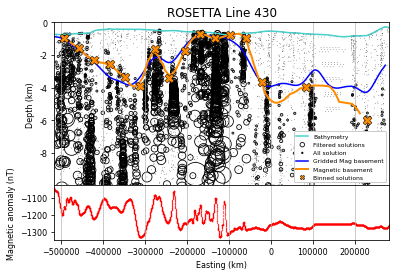

In [67]:
# choose line, and pick parameter values
plot_ROSETTA(
    Line_rs=430,
    
    # random values
    # rs_parameter_s=.3,
    # rs_parameter_w=26000,
    # rs_parameter_b=12000,
    # rs_parameter_c=8)

    # optimized values
    rs_parameter_s=1.2,
    rs_parameter_w=26000,
    rs_parameter_b=36000,
    rs_parameter_c=40)

This figure shows an example of our tie between OIB and ROSETTA magnetic basements, implemented with the two above functions: *filt_and_binning_rs* and *plot_ROSETTA*. It is similar to OIB-ANTOSTRAT figure above, but now ANTOSTRAT basement (blue) has been replaced by OIB magnetic basement. The x axis now easting, instead of distance. 

* bathymetry in light blue at the top
* OIB magnetic basement in dark blue
* airborne magnetic data in the lower panel, pink for ROSETTA and black for OIB
* small black dots show the "depth scatter" of dike solutions from Werner deconvolution, performed in *Oasis Montaj*
* black circles show filtered Werner solutions, scaled to parameter S
     * filtering based on parameter S and W (magnetic susceptibilty*width and Werner window width, respectively) 
* orange crosses show bins with sufficient count of points (paramter c)
     * crosses set to center of bins, and depth's set to 95% of solution depths within bin
* orange line shows interpolation between crosses, used to compare between ROSETTA and OIB

### Re-optimize

Same as the OIB-ANTOSTRAT tie, the above function filt_and_binning_rs has and input of parameters w,s,b, and c, and returns a mean misfit between ROSETTA and OIB basements. We perform the same optimization as above.

#### Parameter space
This will contain a column for each parameter. Each parameter will have 21 values, and the rows will be each unique combination of these parameter values. This results in a total of 194481 combinations.

In [ ]:
s=np.linspace(0, 4, 21)
w=np.linspace(0, 40000, 21, dtype=int)
b=np.linspace(0, 40000, 21, dtype=int)
c=np.linspace(0, 40, 21, dtype=int)
params=[s,w,b,c]         
comb=list(itertools.product(*params))   
df_misfit_rs=pd.DataFrame(comb, columns=['susc', 'window', 'bin', 'count'])

#### Misfit
Apply the function *filt_and_binning_rs* to each row and save the results. Do this for both lines; 590 and 650.  
WARNING, THIS IS VERY SLOW AND MAY TAKE >36H HOURS TO RUN!

In [ ]:
from tqdm import tqdm
tqdm.pandas()
lines=[590, 650]
for l in lines:# look into replacing apply with vectorization
    df_misfit_rs['misfit_{}'.format(l)]=df_misfit_rs.progress_apply(lambda x: filt_and_binning_rs(Line_rs=l,  
                                rs_parameter_s=x['susc'], 
                                rs_parameter_w=x['window'], 
                                rs_parameter_b=x['bin'], 
                                rs_parameter_c=x['count']), axis=1)
df_misfit_rs.describe()

#### Organize
For each row, take the average of the misfits for both 590 and 650.   
Sort by these average values and save as a csv.  

In [ ]:
# average the misfit of lines 590 and 650.
df_misfit_rs['misfit_rs_avg']=df_misfit_rs[['misfit_590', 'misfit_650']].dropna(subset=['misfit_590', 'misfit_650']).mean(axis=1)
# sort from lowest misfit to highest.
df_misfit_rs.sort_values('misfit_rs_avg', inplace=True)
# save as csv
df_misfit_rs.to_csv('data/results/mean_misfit_rs_optimize.csv', index=False)

In [48]:
# load file
df_mean_misfit_rs= pd.read_csv('data/results/mean_misfit_rs_optimize.csv', header=0, index_col=None, sep=',')
# drop first 4 rows; issues with too short of interpolated lines
df_mean_misfit_rs_clip=df_mean_misfit_rs[::]
# df_mean_misfit_rs.sort_values('misfit_rs_avg', inplace=True)
# reset index
df_mean_misfit_rs_clip.reset_index(inplace=True, drop=True)
df_mean_misfit_rs_clip=df_mean_misfit_rs_clip.round(1)
df_mean_misfit_rs_clip.head()

,susc,window,bin,count,misfit_590,misfit_650,misfit_rs_avg
0,1.2,14000,20000,10,520.6,341.3,430.9
1,1.2,14000,30000,8,634.2,230.3,432.2
2,1.2,14000,30000,6,603.9,271.2,437.6
3,0.8,14000,18000,14,547.1,342.4,444.8
4,1.0,14000,16000,10,484.4,411.1,447.7


In [47]:
df_mean_misfit_rs_clip[5:15]

,susc,window,bin,count,misfit_590,misfit_650,misfit_rs_avg
5,1.2,14000,30000,4,629.3,271.2,450.3
6,1.2,14000,34000,4,618.0,287.2,452.6
7,1.0,12000,16000,4,487.5,418.0,452.8
8,1.2,24000,30000,28,618.9,287.9,453.4
9,1.2,24000,30000,26,618.9,287.9,453.4
10,1.2,24000,30000,24,618.9,287.9,453.4
11,1.2,14000,30000,0,627.4,286.3,456.8
12,1.2,14000,30000,2,627.4,286.3,456.8
13,0.8,14000,16000,12,549.7,364.3,457.0
14,1.2,24000,30000,30,618.9,297.9,458.4


In [49]:
df_mean_misfit_rs_clip.query('susc==1.2 and window==26000.0 and bin==36000.0 and count==40.0')

,susc,window,bin,count,misfit_590,misfit_650,misfit_rs_avg
1374,1.2,26000,36000,40,761.7,383.0,572.4


#### Optimize with Optuna
This above optimization can also be accomplished with the python package Optuna. Iteration for iterations, it's much slower, but if you use TPE sample ideally it converges on the minimum misfit much faster.

In [ ]:
# function to combine misfits of both lines 
def combine_rms(Line_A, Line_B, s, b, w, c):
    global misfit_mean
    filt_and_binning_rs(Line_rs = Line_A,
                        rs_parameter_s = s,
                        rs_parameter_w = w,
                        rs_parameter_b = b,
                        rs_parameter_c = c)
    misfit_a = mean_misfit 
    filt_and_binning_rs(Line_rs = Line_B, 
                        rs_parameter_s = s,
                        rs_parameter_w = w,
                        rs_parameter_b = b,
                        rs_parameter_c = c)
    misfit_b = mean_misfit
    misfit_mean = np.mean([misfit_a, misfit_b])
    return misfit_mean

# create optimization study 

# unique identifier of the study. 
study_name = "rosetta_oib_optimize"  

# where to save the results as a .db file 
storage_name = "sqlite:///data/results/{}.db".format(study_name) 

# search_space={'s':np.linspace(0,4,21),
#               'w':np.linspace(0,40_000,21),
#               'b':np.linspace(0,40_000,21),
#               'c':np.linspace(0,40,21)} 
# study = optuna.create_study(study_name=study_name, 
#                             storage=storage_name, 
#                             sampler=optuna.samplers.GridSampler(search_space), 
#                             load_if_exists=True)

study = optuna.create_study(
        study_name=study_name, 
        storage=storage_name, 
        sampler=optuna.samplers.TPESampler(n_startup_trials=100),#number of random runs before TPE sampler starts 
        load_if_exists=True) 

def objective(trial):     
    s = trial.suggest_discrete_uniform('s', 0, 4, 0.2)#0 to 4 in steps of .2
    w = trial.suggest_discrete_uniform('w', 0, 40_000, 2_000)
    b = trial.suggest_discrete_uniform('b', 0, 40_000, 2_000) 
    c = trial.suggest_discrete_uniform('c', 0, 40, 2) 
    combine_rms(Line_A=590,
                Line_B=650,
                s=s, w=w, b=b, c=c) 
    return misfit_mean  

# start optimization

# turn off optuna log notes.
optuna.logging.set_verbosity(optuna.logging.ERROR)

# define custom callbacks
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )
        
study.optimize(objective, n_trials=5000, callbacks=[logging_callback])

# load the study results 
loaded_study = optuna.load_study(study_name=study_name, storage=storage_name) 
study_results = loaded_study.trials_dataframe(attrs=("value", "params", "state")) 
study_results.sort_values(by='value', inplace=True) 
study_results

In [142]:
# load the study results 
loaded_study = optuna.load_study(study_name=study_name, storage=storage_name) 
study_results = loaded_study.trials_dataframe(attrs=("value", "params", "state")) 
study_results.sort_values(by='value', inplace=True) 
study_results

,value,params_b,params_c,params_s,params_w,state
1141,497.734043,28000.0,6.0,1.0,18000.0,COMPLETE
1238,529.540845,30000.0,24.0,1.2,20000.0,COMPLETE
1234,529.540845,30000.0,24.0,1.2,20000.0,COMPLETE
1233,529.540845,30000.0,24.0,1.2,20000.0,COMPLETE
6056,529.540845,30000.0,24.0,1.2,20000.0,COMPLETE
...,...,...,...,...,...,...
6502,NaN,28000.0,24.0,1.2,14000.0,FAIL
6503,NaN,28000.0,24.0,1.2,14000.0,FAIL
6504,NaN,28000.0,24.0,1.2,14000.0,FAIL
6505,NaN,28000.0,24.0,1.2,14000.0,FAIL


# up to date

#### Results

Above are the top 5 sets of parameters which produced the best match between ROSETTA and OIB basement models. We use the values in row 0 as our final optimized parameters.
These values include:
* parameter W: ?? km (maximum Werner window width)
* parameter S: ?? (minimum magnetic susceptibility x body width) 
* parameter B: ?? km (bin width)
* parameter C: ?? (minumum count of solutions / bin)

Using these parameters, we determine magnetic basement points (orange crosses) for all ROSETTA-Ice flight lines, including N-S tie lines.

In [ ]:
for line in (590, 650, 430):     
        # row = 8
        row = 1374
        plot_ROSETTA(Line_rs = line, 
                rs_parameter_s=df_mean_misfit_rs_clip['susc'].iloc[row], 
                rs_parameter_w=df_mean_misfit_rs_clip["window"].iloc[row], 
                rs_parameter_b=df_mean_misfit_rs_clip['bin'].iloc[row], 
                rs_parameter_c=df_mean_misfit_rs_clip['count'].iloc[row])

In [71]:
unique_lines = df0.Line.unique()
other_lines = np.array([403.1, 403.2, 403.3, 404.59, 404.65, 999])
rosetta_lines = np.setdiff1d(unique_lines, other_lines)

tmp_rs_mag=[]
tmp_rs=[]
tmp_rs_basement=[]

# row=8 
row=1374

for l in (rosetta_lines):
    filt_and_binning_rs(Line_rs = l, 
            rs_parameter_s=df_mean_misfit_rs_clip['susc'].iloc[row], 
            rs_parameter_w=df_mean_misfit_rs_clip["window"].iloc[row], 
            rs_parameter_b=df_mean_misfit_rs_clip['bin'].iloc[row], 
            rs_parameter_c=df_mean_misfit_rs_clip['count'].iloc[row])
             # rs_parameter_s=1.2,
             # rs_parameter_w=26000,
             # rs_parameter_b=36000,
             # rs_parameter_c=40)
    tmp_rs_mag.append(rs_mag)
    tmp_rs.append(rs)
    tmp_rs_basement.append(rs_basement)
    
rs_mag = pd.concat(tmp_rs_mag)
rs = pd.concat(tmp_rs)   
rs_basement = pd.concat(tmp_rs_basement)  


rs_mag.to_csv("data/results/rs_mag.csv", index=None)
rs.to_csv("data/results/rs.csv", index=None)
rs_basement.to_csv("data/results/rs_basement.csv", index=None)


In [69]:
tmp_rs_oib_basement=[]

for l in (590, 650):
    filt_and_binning_rs(Line_rs = l, 
            # rs_parameter_s=df_mean_misfit_rs_clip['susc'].iloc[row], 
            # rs_parameter_w=df_mean_misfit_rs_clip["window"].iloc[row], 
            # rs_parameter_b=df_mean_misfit_rs_clip['bin'].iloc[row], 
            # rs_parameter_c=df_mean_misfit_rs_clip['count'].iloc[row])
             rs_parameter_s=1.2,
             rs_parameter_w=26000,
             rs_parameter_b=36000,
             rs_parameter_c=40)
    tmp_rs_oib_basement.append(rs_oib_basement)
    
rs_oib_basement = pd.concat(tmp_rs_oib_basement)  

rs_oib_basement.to_csv("data/results/rs_oib_basement.csv", index=None)

mean misfit: 761.6980298782782 
 median misfit: 607.45083803237
mean misfit: 383.0113549013638 
 median misfit: 312.5343618530763


# Figure S3
Now that we have finished the ROSETTA-OIB optimization, lets recreate the figure from the manuscript. To do this, we need to change directories into the /figures folder, and run the jupyter notebook "Fig_S3_Flight_cross_sections.ipynb".  

Within that same notebook is a function to output all ROSETTA-Ice flight lines as .png files. 

In [ ]:
os.chdir('figures')
os.getcwd()

In [ ]:
%run Fig_S3_Flight_cross_sections.ipynb

Now lets change back to the folder \RIS_basement_sediment

In [ ]:
os.chdir('..')
os.getcwd()

This figure shows a selection of ROSETTA-Ice flight lines over the Ross Ice Shelf, and their resulting magnetic basement solutions. All subplots show bathymetry in light blue, unfiltered solutions as dots, filtered solutions as circles scaled to parameter S, and binned basement solutions as orange crosses.  

a)-d) Orange crosses from all ROSETTA-Ice lines were gridded, and filtered to produce a regional basement model (Figure 2b). This was then sampled onto these profiles and shown as the blue line with uncertaitny bands. This shows the effect of our gridding and filtering process on the original data. It also dislays how crossing E-W and N-S flight lines affect each other at locations where solutions from 1 are different than the others.  

e)-f) These profiles show the comparision between OIB magnetic basement (blue line) and ROSETTA-Ice magnetic basement (orange line), which was used to optimize the ROSETTA-Ice parameters, and tie our final results to ANTOSTRAT offshore seismic basement. 

# Create RIS basement grid

Now we have a series of basement depth points for each ROSETTA-Ice flight line, which we need to turn into a 2D surface. We will use GMT and PyGMT for this. First we need to remove some outliers.

## Quality control

In [ ]:
# load csv's output from "ROSETTA to OIB Tie" section
rs_basement = pd.read_csv("data/results/rs_basement.csv", header=0, index_col=None,sep=',')
# get name of depth column
Depth_bins = rs_basement.columns[11]
# subset of only binned points
rosetta_points=rs_basement[rs_basement.binned==1].copy()
# drop unnecessary columns
rosetta_points.drop(rosetta_points.columns.difference(['x','y',Depth_bins,'Line']),axis=1, inplace=True)
# reorganize column order
rosetta_points=rosetta_points[['x','y',Depth_bins,'Line']]
# rename columns
rosetta_points.columns = ['x','y','z','Line']
# remove outliers based on z score, its 2 points with depths > 9900m (Line 480, 500, index 2758 & 3097)
rosetta_points['zscore']=np.abs(stats.zscore(rosetta_points.z))
rosetta_points.sort_values(by='zscore', ascending=False, inplace=True)
print(rosetta_points.head())
"""
high zscores: 
    Line 480  -> outlier, DELETE
    Line 500  -> outlier, DELETE
    Line 1060 -> deep point near ice front, no results for nearby bins of 810 or 820
    Line 1050 -> first point at ice front is deep, nearby first point 840 is 3k deep 
    Line 630  -> gap in mag data over Roosevelt Island causing deep solution ~6k, DELETE
    Line 680  -> fine
    Line 1090 -> fine
    Line 510  -> fine
"""
# dropped base on z-score
# rosetta_points_cleaned=rosetta_points[(np.abs(stats.zscore(rosetta_points.z)) < 5)].copy()
# dropped by selecting points for lines 480, 500, 630
# also drop anomolously deep point over RI (line 660)

# for previously defined best params
# rosetta_points_cleaned=rosetta_points.drop([2758, 3097, 5457, 6009])
# for possibly updated best params
rosetta_points_cleaned=rosetta_points.drop([2848, 3197])

rosetta_points_cleaned.sort_values(by='z', inplace=True)

pygmt.blockmedian(data=rosetta_points_cleaned[["x", "y", "z",'Line']], 
                 T=0.999999, 
                 spacing="8000+e", 
                 # Q=True,
                 Es=True, # save Line value
                 region=[-760000,600000,-2200000,-350000],
                 outfile='data/results/rosetta_points_blocked.txt') 
    
print("number of starting solutions: {}".format(len(rosetta_points)))
print("number of cleaned starting solutions: {}".format(len(rosetta_points_cleaned)))
print("number after block: {}".format(len(open('data/results/rosetta_points_blocked.txt').readlines())))

## Gridding and filtering

In [ ]:
# grid the points
pygmt.surface(data = 'data/results/rosetta_points_blocked.txt', 
              spacing='5000+e', T=0.35, region='-3330000/1900000/-3330000/1850000', 
              outgrid='data/tmp/rosetta_basement_surface.nc', verbose='e')

# clip the grid back to RIS extent
# use shapefile created with concave hull in QGIS to clip the grid back to data extent
# can replace QGIS hull with geopandas .convex_hull
!gmt grdmask data/input/RIS_outline.shp -Gdata/tmp/RIS_mask.nc -I5000+e -R-3330000/1900000/-3330000/1850000 -NNaN/1/1
!gmt grdmath -Df data/tmp/rosetta_basement_surface.nc data/tmp/RIS_mask.nc MUL = data/results/rosetta_basement_surface_unfiltered.nc
!gmt grdsample data/results/rosetta_basement_surface_unfiltered.nc -Gdata/results/rosetta_basement_surface_unfiltered.nc -T

## PyGMT map function

In [ ]:
# default map extent is for Ross Ice Shelf
def start_fig(n = -1400e3, e = -660e3, s = -400e3, w = 470e3, subplots=False):
    global fig, fig_reg, fig_proj, fig_proj_ll, bardwidth, pos_str
    
    #set figure height, width and map scale
    fig_height = 180 # in mm
    fig_width = fig_height*(w-e)/(s-n)
    fig_ratio = (s-n)/(fig_height/1000)

    # Make a GMT region string and projection strings in both ESPG3031 and Lat/Lon
    fig_reg = str(e) + '/' + str(w) + '/' + str(n) + '/' + str(s)
    fig_proj = "x1:" + str(fig_ratio)
    fig_proj_ll = "s0/-90/-71/1:" + str(fig_ratio)

    # colorbar width and position
    barwidth = fig_width/10 * 0.8 # color bar width is 40% of the map width, in cm
    pos_str = 'jBC+w' + str(barwidth) + 'c/.5c+jTC+o0c/.2c+h+e'
    
    # initialize figure
    if subplots==False:
        fig = pygmt.Figure()
    # if adding a suplot, don't re-initialize, but move origin over    
    else:
        fig.shift_origin(xshift=fig_width/10)
    
    # add white background and frame
    fig.coast(region = fig_reg, projection = fig_proj_ll, land = 'white', water = 'white', 
              frame = ["nwse", "xf100000", "yf100000", "g0"],verbose='e')
    
    # plot graticules overtop, at 4d latitude and 30d longitude
    with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '8p,black', 
                  MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                  MAP_TICK_PEN_PRIMARY = 'thinnest,grey', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90', ):
        fig.basemap(projection = fig_proj_ll, frame = ["NSWE", "xa30g15", "ya4g2"], verbose='e')

## Show results
Simple plot to show basement point solutions, and gridded data.

In [ ]:
start_fig()

# read basement points from .txt
data=pd.read_csv('data/results/rosetta_points_blocked.txt', names=('x','y','z','Line'), header=None, delim_whitespace=True)
# make color ramp scaled to points
pygmt.makecpt(cmap="batlow", series=[data.z.min(), data.z.max()])

# plot points
fig.plot(projection=fig_proj, 
         data="data/results/rosetta_points_blocked.txt",
         style = 'c.2c', 
         cmap=True, 
         pen='thinnest,black')

# add colorbar
with pygmt.config(FONT_ANNOT_PRIMARY = '18p,black', FONT_LABEL = '20p,black'):
    fig.colorbar(cmap=True, position = pos_str, 
             frame=['xa1000f100+l"Basement elevation (m)"'], verbose='e')

start_fig(subplots=True)

# make colorscale
pygmt.grd2cpt(grid='data/results/rosetta_basement_surface_unfiltered.nc', 
              cmap='batlow', region=fig_reg, continuous=True)
# plot grid
fig.grdimage(projection = fig_proj,
             grid='data/results/rosetta_basement_surface_unfiltered.nc',
             cmap=True, nan_transparent=True)

# colorbar
with pygmt.config(FONT_ANNOT_PRIMARY = '18p,black', FONT_LABEL = '20p,black'):
    fig.colorbar(cmap=True, position = pos_str, 
                 frame=['xa1000f100+l"Basement elevation (m)"'], verbose='e')     

fig.show(width=1000) 

# Figure S4
Running the function from "Fig_S4_unfiltered_basement.ipynb" lets us plot all ROSETTA lines, while highlighting a subset. Type in line numbers to the function to choose which lines are highlighted.

Change into figures folder

In [ ]:
os.chdir('figures')
os.getcwd()

In [ ]:
%run Fig_S4_unfiltered_basement.ipynb     #this is were the 'make_grid' function is stored
make_grid(lines=(270,310,410,430,590,650))

Now lets change back to the folder \RIS_basement_sediment

In [ ]:
os.chdir('..')
os.getcwd()

# Merge with offshore basement

## Process
Here we use a regional compilation of sediment thickness, and subtract it from bathymetry to get basement depths. This data, from Lindeque et al. 2016, mostly consists of ANTOSTRAT seismic basement for the Ross Sea. 

In [ ]:
# use offshore basement model which we already made for Figure 1
# data/results/Lindeque_bedmachine_basement.nc

# merge with ice shelf results
# -Cf is clobber mode, just takes the value of the first grid instead of blending
!gmt grdblend -Cf data/results/rosetta_basement_surface_unfiltered.nc data/results/Lindeque_bedmachine_basement.nc -Gdata/tmp/rosetta_lindeque_basement.nc -rp -I5000+e -R-3330000/1900000/-3330000/1850000

# filter merged grid with a 80 km Gaussian filter
pygmt.grdfilter(grid='data/tmp/rosetta_lindeque_basement.nc', filter='g80000', nans='r', distance='0', outgrid='data/results/Ross_Embayment_basement_filt_updated.nc')

## Show results

In [ ]:
# initialize figure but extend plot north into Ross Sea
# start_fig(n = -2200e3)
start_fig()

grid='data/results/Ross_Embayment_basement_filt.nc'

# make colorscale
pygmt.grd2cpt(grid=grid, 
              cmap='batlow', 
              region=fig_reg, 
              continuous=True)

# plot grid
fig.grdimage(projection = fig_proj,
             grid=grid,
             cmap=True, 
             nan_transparent=True,)

# add contours
fig.grdcontour(grid=grid, 
               interval=500, 
               pen='thinner,black')

# colorbar
with pygmt.config(FONT_ANNOT_PRIMARY = '12p,black', FONT_LABEL = '16p,black'):
    fig.colorbar(cmap=True, position = pos_str, 
                 frame=['xa2000f500+l"Basement elevation (m)"'], verbose='e') 
    
start_fig(subplots=True)

grid='data/results/Ross_Embayment_basement_filt_updated.nc'

# plot grid
fig.grdimage(projection = fig_proj,
             grid=grid,
             cmap=True, 
             nan_transparent=True,)

# add contours
fig.grdcontour(grid=grid, 
               interval=500, 
               pen='thinner,black')

# colorbar
with pygmt.config(FONT_ANNOT_PRIMARY = '12p,black', FONT_LABEL = '16p,black'):
    fig.colorbar(cmap=True, position = pos_str, 
                 frame=['xa2000f500+l"Updated basement elevation (m)"'], verbose='e') 

    
start_fig(subplots=True)

!gmt grdmath data/results/Ross_Embayment_basement_filt.nc data/results/Ross_Embayment_basement_filt_updated.nc SUB = data/results/diff.nc

grid='data/results/diff.nc'

# make colorscale
pygmt.grd2cpt(grid=grid, 
              cmap='polar+h0', 
              region=fig_reg, 
              continuous=True)

# plot grid
fig.grdimage(projection = fig_proj,
             grid=grid,
             cmap=True, 
             nan_transparent=True,)

# add contours
fig.grdcontour(grid=grid, 
               interval=500, 
               pen='thinner,black')

# colorbar
with pygmt.config(FONT_ANNOT_PRIMARY = '12p,black', FONT_LABEL = '16p,black'):
    fig.colorbar(cmap=True, position = pos_str, 
                 frame=['xa500f10+l"Diff (m)"'], verbose='e')     

fig.show(width=1000) 

# Calculate sediment thickness

## Process

In [ ]:
# subtract bathymetry elevations from basement elevation to get sediment thickness
# using bedmachine v2 bathymetry, which under the ice shelf is from ROSETTA-Ice gravity inversion (Tinto et al. 2019)
!gmt grdmath data/results/BedMachine_bed_5k_wgs.nc data/results/Ross_Embayment_basement_filt.nc SUB = data/results/Ross_Embayment_sediment.nc

# make colorbar
pygmt.makecpt(cmap='acton', background='o', series = '0/3000', reverse=True, output='data/results/sediment.cpt')

## Show results

In [ ]:
# initialize figure but extend plot north into Ross Sea
start_fig(n = -2200e3)

# make colorscale
pygmt.grd2cpt(grid='data/results/Ross_Embayment_sediment.nc', cmap='acton',
             reverse=True, region=fig_reg, continuous=True)
# plot grid
fig.grdimage(projection = fig_proj,
             grid='data/results/Ross_Embayment_sediment.nc',
             cmap=True, 
             nan_transparent=True)

# add contours
fig.grdcontour(grid='data/results/Ross_Embayment_sediment.nc', 
               interval=500, 
               pen='thinner,black')

# colorbar
with pygmt.config(FONT_ANNOT_PRIMARY = '12p,black', FONT_LABEL = '16p,black'):
    fig.colorbar(cmap=True, position = pos_str, 
                 frame=['xa2000f500+l"Sediment thickness (m)"'], verbose='e') 

fig.show(width=500) 

# Figure 3
Now we can re-create Figure 3, which is the main results figure, showing Ross Embayment basement topography and sediment thicknes.

Change into figures folder

In [34]:
os.chdir('figures')
os.getcwd()

'C:\\Users\\mtankersley\\Documents\\Python_Scripts\\RIS_basement_sediment\\figures'

In [ ]:
%run Fig3_Base_Sed.ipynb

Now lets change back to the folder \RIS_basement_sediment

In [35]:
os.chdir('..')
os.getcwd()

'C:\\Users\\mtankersley\\Documents\\Python_Scripts\\RIS_basement_sediment'

## Uncertainties
Here we develop a representative uncertainty for our results by comparison between our two sets of ties. We start by showing the non-normal distribution of the misfits. The histograms show that the large misfits are skewing our results, and that the median value of the misfits is more representative of the data than the mean value of the misfits.

In [91]:
# OIB to ANTOSTRAT comparison
oib_to_anto = pd.read_csv("data/results/oib_basement.csv", header=0, index_col=None,sep=',')
oib_to_anto = oib_to_anto[['Line', 'ANTOSTRAT_basement', 'filt_clip']]
oib_to_anto.rename(columns={'filt_clip':'OIB_basement'}, inplace=True) 
oib_to_anto['dif'] = oib_to_anto.ANTOSTRAT_basement - oib_to_anto.OIB_basement
oib_to_anto['abs_dif'] = np.abs(oib_to_anto.dif)

# ROSETTTA to OIB comparison
rosetta_to_oib = pd.read_csv("data/results/rs_oib_basement.csv", header=0, index_col=None,sep=',')
rosetta_to_oib = rosetta_to_oib[['Line', 'filt_clip','filt_clip_oib']]
rosetta_to_oib.rename(columns={'filt_clip':'ROSETTA_basement', 'filt_clip_oib':'OIB_basement'}, inplace=True) 
rosetta_to_oib['dif'] = rosetta_to_oib.ROSETTA_basement - rosetta_to_oib.OIB_basement
rosetta_to_oib['abs_dif'] = np.abs(rosetta_to_oib.dif)

### Misfit distributions

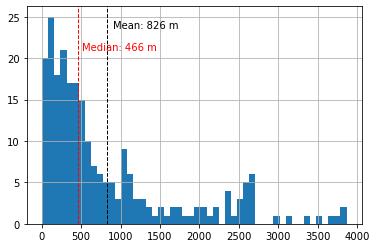

In [125]:
oib_to_anto.abs_dif.hist(bins=50)
min_ylim, max_ylim = plt.ylim()

plt.axvline(oib_to_anto.abs_dif.mean(), color='k', linestyle='dashed', linewidth=1)
text = 'Mean: '+str(int(oib_to_anto.abs_dif.mean()))+' m'
plt.text(oib_to_anto.abs_dif.mean()*1.1, max_ylim*0.9, text, color='k')

plt.axvline(oib_to_anto.abs_dif.median(), color='r', linestyle='dashed', linewidth=1)
text = 'Median: '+str(int(oib_to_anto.abs_dif.median()))+' m'
plt.text(oib_to_anto.abs_dif.median()*1.1, max_ylim*0.8, text, color='r')

plt.show()
# print('ANT to OIB 403.1:\n','mean:',oib_to_anto[oib_to_anto.Line==403.1].abs_dif.mean(),'\n median:',oib_to_anto[oib_to_anto.Line==403.1].abs_dif.median(),'\n')
# print('ANT to OIB 403.3:\n','mean:',oib_to_anto[oib_to_anto.Line==403.3].abs_dif.mean(),'\n median:',oib_to_anto[oib_to_anto.Line==403.3].abs_dif.median(),'\n')
# print('ANT to OIB overall:\n','mean:',oib_to_anto.abs_dif.mean(),'\n median:',oib_to_anto.abs_dif.median())

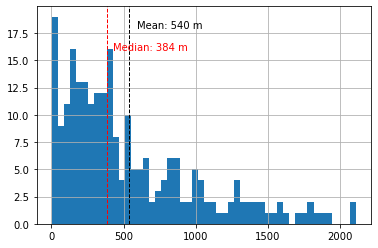

In [126]:
rosetta_to_oib.abs_dif.hist(bins=50)
min_ylim, max_ylim = plt.ylim()

plt.axvline(rosetta_to_oib.abs_dif.mean(), color='k', linestyle='dashed', linewidth=1)
text = 'Mean: '+str(int(rosetta_to_oib.abs_dif.mean()))+' m'
plt.text(rosetta_to_oib.abs_dif.mean()*1.1, max_ylim*0.9, text, color='k')

plt.axvline(rosetta_to_oib.abs_dif.median(), color='r', linestyle='dashed', linewidth=1)
text = 'Median: '+str(int(rosetta_to_oib.abs_dif.median()))+' m'
plt.text(rosetta_to_oib.abs_dif.median()*1.1, max_ylim*0.8, text, color='r')

plt.show()
# print('OIB to ROSETTA 590:\n','mean:',rosetta_to_oib[rosetta_to_oib.Line==590].abs_dif.mean(),'\n median:',rosetta_to_oib[rosetta_to_oib.Line==590].abs_dif.median(),'\n')
# print('OIB to ROSETTA 650:\n','mean:',rosetta_to_oib[rosetta_to_oib.Line==650].abs_dif.mean(),'\n median:', rosetta_to_oib[rosetta_to_oib.Line==650].abs_dif.median(),'\n')
# print('OIB to ROSETTA overall:\n','mean:',rosetta_to_oib.abs_dif.mean(),'\n median:', rosetta_to_oib.abs_dif.median())

### Depth dependence

The figure below shows the relationship between basement depth and the median absolute value of misfits. This shows there is *not* a strong depth-dependence on our misfits, and justifies our use of a uniform representative uncertainty. The small dots represent all the misfit points, and the large dots are the poitns grouped into 200 m basement depth bins

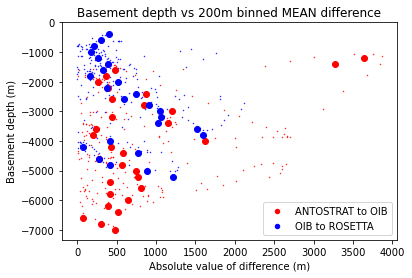

In [134]:
plt.scatter(x=oib_to_anto.abs_dif, y=oib_to_anto.OIB_basement,  c='r', s=.2, label='ANTOSTRAT to OIB')
plt.scatter(x=rosetta_to_oib.abs_dif, y=rosetta_to_oib.ROSETTA_basement,  c='b', s=.2, label='OIB to ROSETTA')

oib_to_anto['depth_bins']= np.floor(oib_to_anto.OIB_basement/200)*200
for i in oib_to_anto.depth_bins.unique():
    plt.errorbar(x=oib_to_anto.abs_dif[oib_to_anto.depth_bins==i].median(), 
                 y=oib_to_anto.depth_bins[oib_to_anto.depth_bins==i].median(), 
                 c='r', fmt='o',)

rosetta_to_oib['depth_bins']= np.floor(rosetta_to_oib.ROSETTA_basement/200)*200
for i in rosetta_to_oib.depth_bins.unique():
    plt.errorbar(x=rosetta_to_oib.abs_dif[rosetta_to_oib.depth_bins==i].median(), 
                 y=rosetta_to_oib.depth_bins[rosetta_to_oib.depth_bins==i].median(), 
                 c='b', fmt='o',)
    
plt.title('Basement depth vs 200m binned MEAN difference')
plt.ylabel('Basement depth (m)')
plt.xlabel('Absolute value of difference (m)')
plt.legend(markerscale=10)

### Basement elevation uncertainty
* Comparison between ROSETTA and OIB basements gives a median absolute value of misfit of 380m. 

* Comparison between OIB and ANTOSTRAT basements gives a median absolute value of misfit of 470m. 


### Sediment thickness uncertainty
Since our sediment thickness is calculated by subtracting a bathymetry model, our representative uncertianty for the sediment thickness is the combination of basement and bathymetry uncertainty. We use BedMachine bathymetry, which for the sub-Ross Ice Shelf is from inversion of ROSETTA-Ice gravity (Tinto et al. 2019). This inversion states an uncertainty of 68m, which adding to our basement uncertainty yields 530m. This equates to 

In [139]:
68+470

538

In [ ]:
!gmt grdino -La 

# Figure S5
Now we can re-create Figure S5. This is a 4 panel figure showing the uncertainties of the two mains results of this study; basement topography and sediment thickness. Lower limits are in a) and c), upper limits are in b) and d).

In [ ]:
os.chdir('figures')
os.getcwd()

In [ ]:
%run Fig_S5_uncertainties.ipynb

Now lets change back to the folder \RIS_basement_sediment

In [ ]:
os.chdir('..')
os.getcwd()

# Beta factor calculation

Here we will make our calculations of beta crustal stretching factors. This is a simple calculation of initial crustal thickness / final crustal thickness. For this, we assume the crustal was initially a uniform 38km thick slab. The final crustal thickness is calculated as the depth of the Moho to the top of the basement surface. For this, we use a Antarctic Moho model from passive seismics.

## Process

In [ ]:
# reproject Moho depths from lat/long to EPSG3031
!gmt grdproject data/input/AN1-CRUST.grd -Gdata/tmp/AN1-CRUST_EPSG3031.nc -JEPSG:3031

# change spacing and region to match basement grid
!gmt grdsample data/tmp/AN1-CRUST_EPSG3031.nc -Gdata/tmp/AN1-CRUST_EPSG3031_5k.nc -Rdata/results/Ross_Embayment_basement_filt.nc

# turn Moho depths in +km to -m 
!gmt grdmath data/tmp/AN1-CRUST_EPSG3031_5k.nc -1000 MUL = data/tmp/AN1-CRUST_EPSG3031_5k.nc

# substract basement depths from Moho depths to final crustal thickness without sediments
!gmt grdmath data/results/Ross_Embayment_basement_filt.nc data/tmp/AN1-CRUST_EPSG3031_5k.nc SUB = data/results/Ross_Embayment_crustal_thickness.nc

# calculate beta factors, divide initial thickness, 38km, by current thickness
!gmt grdmath 38000 data/results/Ross_Embayment_crustal_thickness.nc DIV = data/results/Ross_Embayment_beta.nc

## Show results

In [ ]:
# initialize figure but extend plot north into Ross Sea
start_fig()

ris_reg='-700000/450000/-1200000/-350000'

# make colorscale set to Ross Ice Shelf region
pygmt.grd2cpt(cmap='haxby', region=ris_reg, continuous=True, 
              grid='data/results/Ross_Embayment_beta.nc', background=True)

# plot grid
fig.grdimage(projection = fig_proj,
             grid='data/results/Ross_Embayment_beta.nc',
             cmap=True)

# colorbar
with pygmt.config(FONT_ANNOT_PRIMARY = '16p,black', FONT_LABEL = '20p,black'):
    fig.colorbar(cmap=True, position = pos_str, 
                 frame=['xa.2f+l"Beta factors"'], verbose='e') 

# plot groundingline and coastlines
fig.plot(projection=fig_proj, data=gpd.read_file('data/input/GroundingLine_Antarctica_v02.shp'), 
         pen = '1.2p,black', verbose='e')
fig.plot(data=gpd.read_file('data/input/Coastline_Antarctica_v02.shp'), 
         pen='1.2p,black', verbose='e')
    
fig.show(width=500) 

# Figure 4
Now we can re-create Figure 4. This is a 2 panel figure, should Ross Ice Shelf beta factors and interpreted fault locations in panel a, and a cross-section of the Siple Coast, showing real and schematic data in panel b. All of panel a, and the majority of panel b is create with the below notebook, but this interpreted portions of panel b were created using Corel Draw and Inkscape.

Change into figures folder

In [ ]:
os.chdir('figures')
os.getcwd()

In [ ]:
%run Fig4_Beta.ipynb

Now lets change back to the folder \RIS_basement_sediment

In [ ]:
os.chdir('..')
os.getcwd()

# Figure S1
Now we can re-create Figure S1. This is a 6 panel figure, showing various gridded dataset for the Ross Ice Shelf area. These include a) free-air gravity, b) magnetics, c) our sediment thickness, d) previous estimates of sediment thickness, e) bathymetry, and f) differece between the two sediment thickness models

In [ ]:
os.chdir('figures')
os.getcwd()

In [ ]:
%run Fig_S1_6_panel_plot.ipynb

Now lets change back to the folder \RIS_basement_sediment

In [ ]:
os.chdir('..')
os.getcwd()